## Data analytics

### Data loading for a serach word

#### data processing from DB (nltk work)

In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('resources/filtered_database.db')
cursor = conn.cursor()


cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [table[0] for table in cursor.fetchall()]


df_list = []

for table_name in tables:

    cursor.execute(f"PRAGMA table_info('{table_name}');")
    columns = [column[1] for column in cursor.fetchall()]
    
    cursor.execute(f"SELECT * FROM {table_name};")
    rows = cursor.fetchall()

    df = pd.DataFrame(rows, columns=columns)

    df['table_name'] = table_name
    

    df_list.append(df)

merged_df = pd.concat(df_list, ignore_index=True)

df = merged_df.copy()

conn.close()

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x77152a2e1ac0>>
Traceback (most recent call last):
  File "/scratch/prj/inf_wqp/ISWC_paper/ISWCEnv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import seaborn as sns


nltk.download('stopwords')

# Assuming 'df' is your DataFrame
# Preprocess the text
def preprocess(text):
    # Using regex to clean the text and then splitting into tokens
    text = re.sub(r'\W', ' ', str(text))
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub(r'^b\s+', '', text)
    text = text.lower()
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3]
    return ' '.join(tokens)

# Apply preprocessing to the abstracts
df['processed_abstracts'] = df['abstract'].apply(preprocess)
df.to_pickle('resources/processedDF.pkl')


#### Load processed DF

In [1]:
import pandas as pd
df = pd.read_pickle('resources/processedDF.pkl')

### LDA topic modeling

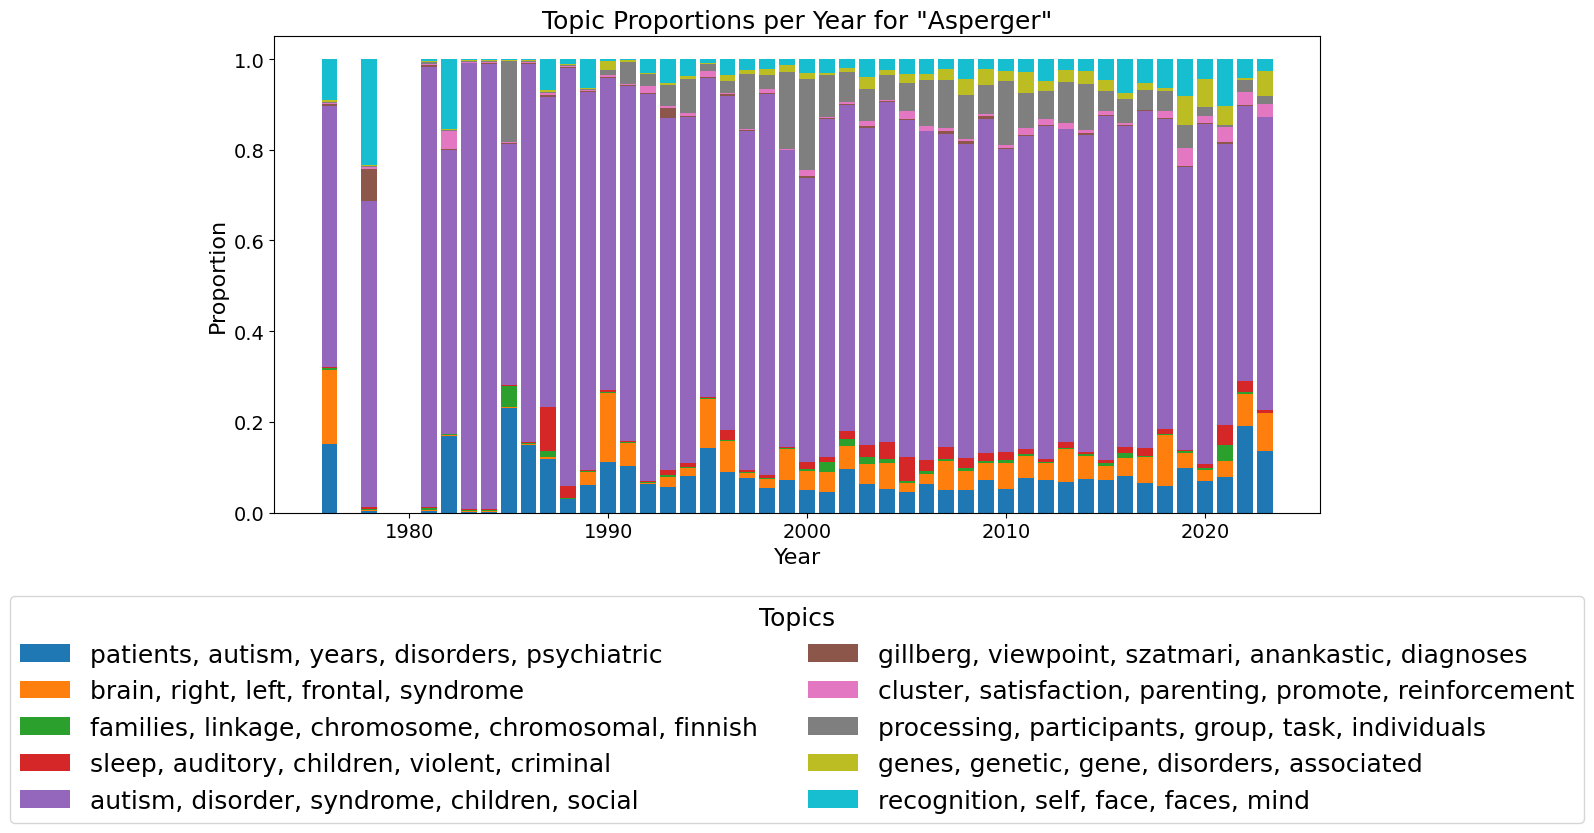

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from tqdm import tqdm

plt.rcParams.update({'font.size': 14})

df = pd.read_pickle('resources/processedDF.pkl')
original_df = df.copy()

original_df = original_df.dropna(subset=['year', 'abstract'])
original_df['year'] = original_df['year'].astype(int)
unique_search_words = original_df['searchWord'].unique()

uw = 'Asperger'
df = original_df[original_df['searchWord']==uw].copy()

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_vectorized = vectorizer.fit_transform(df['processed_abstracts'])

lda_model = LatentDirichletAllocation(n_components=10, max_iter=10, learning_method='online', random_state=100)
lda_model.fit(data_vectorized)

theta = lda_model.transform(data_vectorized)

def get_top_words(model, feature_names, n_top_words):
    top_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_words[f"Topic {topic_idx+1}"] = ", ".join(top_features)
    return top_words

top_n_words = get_top_words(lda_model, vectorizer.get_feature_names_out(), 5)

topic_distributions = pd.DataFrame(theta, columns=[top_n_words[f"Topic {i+1}"] for i in range(lda_model.n_components)])
topic_distributions = topic_distributions.reset_index(drop=True)
df = df.reset_index(drop=True)
topic_distributions['year'] = df['year']

mean_topic_props = topic_distributions.groupby('year').mean().reset_index()
melted_data = pd.melt(mean_topic_props, id_vars=['year'], var_name='topic', value_name='proportion')

fig, ax = plt.subplots(figsize=(15, 10))  # figsize 조정

cumulative_proportions = np.zeros(len(mean_topic_props))
for i, topic in enumerate(top_n_words.values()):
    ax.bar(mean_topic_props['year'], mean_topic_props[topic], bottom=cumulative_proportions, width=0.8, label=topic)
    cumulative_proportions += mean_topic_props[topic].values

ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Proportion', fontsize=16)
ax.set_title(f'Topic Proportions per Year for "{uw}"', fontsize=18)

# 레전드를 그래프 아래로 이동
ax.legend(title='Topics', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=18, title_fontsize=18)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # 그래프 영역을 위로 올림
plt.show()

### Word2Vec-based trend visualisation

In [80]:
grouped_abstracts

year
1951.0    [children retarded readers present complex pro...
1965.0    [chronic fixed neurological deficits appear en...
1967.0    [national disaster medical profession would lo...
1968.0    [brilliantly magnified stereoscopic view opera...
1971.0    [sibs heredopathia atactica polyneuritiformis ...
1975.0    [fifty lymphograms performed children indicati...
1976.0    [twenty patients cerebral arteriosclerosis tre...
1977.0    [sixteen early blinded adults normally sighted...
1978.0    [tests determining dominant hearing high tone ...
1979.0    [study explores relationship time complete man...
1980.0    [handedness seventy five persons without evide...
1981.0    [presentation summarizes characteristics deter...
1982.0    [importance film documentation objective quant...
1983.0    [effects benzodiazepine hypnotic loprazolam al...
1984.0    [twenty rheumatoid arthritis randomly assigned...
1985.0    [chip avulsion fractures hand range severity d...
1986.0    [last years steady declin

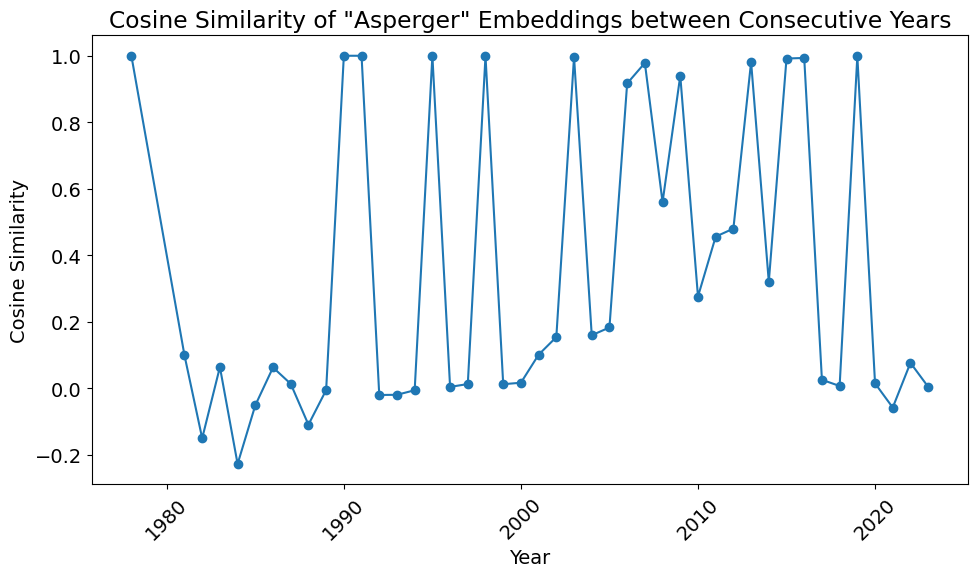

In [86]:
from gensim.models import Word2Vec
import pandas as pd
df = pd.read_pickle('resources/processedDF.pkl')

keyword = 'Asperger'

df = df.dropna(subset=['year', 'abstract'])
df = df[df['searchWord']==keyword].copy()

keyword = keyword.lower()
# Group the abstracts by year
grouped_abstracts = df.groupby('year')['processed_abstracts'].apply(list)

# Train Word2Vec models for each year
embedding_models = {}
for year, abstracts in grouped_abstracts.items():
    sentences = [abstract.split() for abstract in abstracts]
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
    embedding_models[year] = model

import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

# Get the embedding for the keyword "Dexterity" in each year
embeddings = {}
years = sorted(embedding_models.keys())

for year in years:
    model = embedding_models[year]
    if keyword in model.wv.key_to_index:
        embedding = model.wv[keyword]
        embeddings[year] = embedding


# Calculate cosine similarity between consecutive years
similarities = []
for i in range(1, len(years)):
    prev_year = years[i - 1]
    curr_year = years[i]
    if prev_year in embeddings and curr_year in embeddings:
        prev_embedding = embeddings[prev_year]
        curr_embedding = embeddings[curr_year]
        similarity = 1 - cosine(prev_embedding, curr_embedding)
        similarities.append(similarity)
    else:
        similarities.append(None)

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(years[1:], similarities, marker='o')
plt.xlabel('Year')
plt.ylabel('Cosine Similarity')
keyword = keyword.capitalize()
plt.title(f'Cosine Similarity of "{keyword}" Embeddings between Consecutive Years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForMaskedLM, AdamW


# Define the dataset class
class AbstractDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        abstract = self.dataframe.iloc[idx]['processed_abstracts']
        encoding = self.tokenizer.encode_plus(
            abstract,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Initialize the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained('roberta-base')

# Set the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Create the dataset and dataloader
max_length = 128  # Adjust as needed
dataset = AbstractDataset(df, tokenizer, max_length)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Set up the optimizer, learning rate, and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Fine-tune the model
num_epochs = 3
model.train()
for epoch in range(num_epochs):
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Create masked input ids
        mask_indices = torch.bernoulli(torch.full(input_ids.shape, 0.15)).bool()
        masked_input_ids = input_ids.clone()
        target_ids = input_ids.clone()
        masked_input_ids[mask_indices] = tokenizer.mask_token_id
        
        optimizer.zero_grad()
        outputs = model(masked_input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Reshape logits and target_ids for loss calculation
        logits = logits.view(-1, tokenizer.vocab_size)
        target_ids = target_ids.view(-1)
        
        # Calculate the loss
        loss = criterion(logits, target_ids)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Save the fine-tuned model
model.save_pretrained('resources/fine-tuned/fine_tuned_roberta')

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForMaskedLM, AdamW

# Define the dataset class
class AbstractDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        abstract = self.dataframe.iloc[idx]['processed_abstracts']
        encoding = self.tokenizer.encode_plus(
            abstract,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Set the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up the learning rate and loss function
learning_rate = 2e-5
criterion = torch.nn.CrossEntropyLoss()

# Fine-tune the model for each year
num_epochs = 3
max_length = 1024  # Adjust as needed

# Group the DataFrame by year
grouped_df = df.groupby('year')

for year, year_df in grouped_df:
    print(f"Fine-tuning for year: {year}")
    
    # Create the dataset and dataloader for the current year
    dataset = AbstractDataset(year_df, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    
    # Initialize a new RoBERTa model for each year
    model = RobertaForMaskedLM.from_pretrained('roberta-base')
    model.to(device)
    
    # Set up the optimizer for the current year's model
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    # Fine-tune the model for the current year
    model.train()
    for epoch in range(num_epochs):
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Create masked input ids
            mask_indices = torch.bernoulli(torch.full(input_ids.shape, 0.15)).bool()
            masked_input_ids = input_ids.clone()
            target_ids = input_ids.clone()
            masked_input_ids[mask_indices] = tokenizer.mask_token_id
            
            optimizer.zero_grad()
            outputs = model(masked_input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Reshape logits and target_ids for loss calculation
            logits = logits.view(-1, tokenizer.vocab_size)
            target_ids = target_ids.view(-1)
            
            # Calculate the loss
            loss = criterion(logits, target_ids)
            loss.backward()
            optimizer.step()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    
    # Save the fine-tuned model for the current year
    model.save_pretrained(f'resources/fine-tuned/fine_tuned_roberta_{year}')

### BERT-based trend visualisation

#### roBERTa fine-tune

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForMaskedLM, AdamW
import gc

# Define the dataset class
class AbstractDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        abstract = self.dataframe.iloc[idx]['processed_abstracts']
        encoding = self.tokenizer.encode_plus(
            abstract,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Set the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set up the learning rate and loss function
learning_rate = 2e-5
criterion = torch.nn.CrossEntropyLoss()

# Fine-tune the model for each year
num_epochs = 50
max_length = 512


# Group the DataFrame by year
grouped_df = df[df['year'] >= 1970].groupby('year')

for year, year_df in grouped_df:
    print(f"Fine-tuning for year: {year}")
    
    # Create the dataset and dataloader for the current year
    dataset = AbstractDataset(year_df, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    # Initialize a new RoBERTa model for each year
    model = RobertaForMaskedLM.from_pretrained('roberta-base')
    model.to(device)
    
    # Set up the optimizer for the current year's model
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    # Fine-tune the model for the current year
    model.train()
    for epoch in range(num_epochs):
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Create masked input ids
            mask_indices = torch.bernoulli(torch.full(input_ids.shape, 0.15)).bool()
            masked_input_ids = input_ids.clone()
            target_ids = input_ids.clone()
            masked_input_ids[mask_indices] = tokenizer.mask_token_id
            
            optimizer.zero_grad()
            outputs = model(masked_input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Reshape logits and target_ids for loss calculation
            logits = logits.view(-1, tokenizer.vocab_size)
            target_ids = target_ids.view(-1)
            
            # Calculate the loss
            loss = criterion(logits, target_ids)
            loss.backward()
            optimizer.step()
        
        #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    
    # Save the fine-tuned model for the current year
    model.save_pretrained(f'resources/fine-tuned/fine_tuned_roberta_{year}')
    del model
    del optimizer
    torch.cuda.empty_cache()  # Clear memory cache
    torch.cuda.synchronize()  # Wait for all kernels to finish
    gc.collect()  # Collect garbage



/scratch/prj/inf_wqp/ISWC_paper/ISWCEnv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fine-tuning for year: 1970.0


/scratch/prj/inf_wqp/ISWC_paper/ISWCEnv/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fine-tuning for year: 1971.0


/scratch/prj/inf_wqp/ISWC_paper/ISWCEnv/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fine-tuning for year: 1972.0
Fine-tuning for year: 1973.0
Fine-tuning for year: 1974.0
Fine-tuning for year: 1975.0


KeyboardInterrupt: 

#### fine-tune based embedding vectors obtaining and plotting

### Finding exmaples

In [ ]:
print(df[(df['year'] <= 1950) & (df['searchWord'] == 'Depression')][['abstract', 'year']])
print(df[(df['year'] >= 2015) & (df['searchWord'] == 'Depression')][['abstract', 'year']])


In [8]:
import pandas as pd
df = pd.read_pickle('resources/processedDF.pkl')

In [12]:
d = df.groupby('searchWord')[['pmid', 'processed_abstracts', 'year']].agg(
    n_samples=('pmid', 'count'),
    period=('year', lambda x: f"{int(x.min())} - {int(x.max())}"),  
    tokens=('processed_abstracts', lambda x: sum(len(y.split()) for y in x)),
    types=('processed_abstracts', lambda x: sum(len(set(y.split())) for y in x)),
    TTR=('processed_abstracts', lambda x: sum(len(set(y.split())) / len(y.split()) if len(y.split()) > 0 else 0 for y in x) / len(x))
).reset_index()
d

,searchWord,n_samples,period,tokens,types,TTR
0,Asperger,1451,1976 - 2023,119401,89832,0.785111
1,Astigmatism,5308,1966 - 2024,322810,245159,0.832304
2,Autism spectrum disorder,27829,1996 - 2024,2485471,1859270,0.789955
3,Blindness,23107,1933 - 2024,2412735,1859987,0.806964
4,Deafness,12118,1928 - 2024,1062506,803445,0.795817
5,Dementia,95134,1915 - 2024,7740270,5881239,0.807260
6,Depression,237026,1897 - 2024,21297053,15361096,0.768173
7,Dexterity,3913,1951 - 2024,496215,368860,0.773973
8,Dyslexia,4075,1971 - 2024,413719,294734,0.745017
9,Emotional disorders,1947,1955 - 2024,188533,138798,0.771538


In [14]:
df = pd.read_pickle('resources/processedDF.pkl')
df

,pmid,title,abstract,year,searchWord,mesh,table_name,id,processed_abstracts
0,33946206,Effect of a 6-Week Physical Education Interven...,The objective of this research was to analyze ...,2021.0,Dexterity,,articles,NaN,objective research analyze impact intervention...
1,33963093,Influence of Chronotype on Motor Behavior in H...,This study investigated the influence of chron...,2021.0,Dexterity,Adult|Circadian Rhythm|Humans|Motor Activity|S...,articles,NaN,study investigated influence chronotype motor ...
2,33967897,Computerized Symbol Digit Modalities Test in a...,Information processing speed (IPS) is a marker...,2021.0,Dexterity,,articles,NaN,information processing speed marker cognitive ...
3,33968665,Narrative review of the history of microsurger...,The clinical need for magnified visualization ...,2021.0,Dexterity,,articles,NaN,clinical need magnified visualization surgery ...
4,32839680,Clinical Reasoning: A 75-Year-Old Man With Dem...,Idiopathic normal pressure hydrocephalus (iNPH...,2020.0,Dexterity,,articles,NaN,idiopathic normal pressure hydrocephalus inph ...
...,...,...,...,...,...,...,...,...,...
586155,NaN,The shape of (7) Iris as evidence of an ancien...,Asteroid (7) Iris is an ideal target for dis...,2019.0,Depression,NaN,papers,1902.09242v1,asteroid iris ideal target disk resolved imagi...
586156,NaN,Chemical Cartography with APOGEE: Mapping Disk...,We apply a novel statistical analysis to mea...,2021.0,Depression,NaN,papers,2108.08860v1,apply novel statistical analysis measurements ...
586157,NaN,Molecules with ALMA at Planet-forming Scales (...,Constraining the distribution of gas and dus...,2021.0,Depression,NaN,papers,2109.06223v2,constraining distribution dust inner protoplan...
586158,NaN,"FRESCO: An extended, massive, rapidly rotating...",With the remarkable sensitivity and resoluti...,2023.0,Depression,NaN,papers,2310.06887v1,remarkable sensitivity resolution jwst infrare...


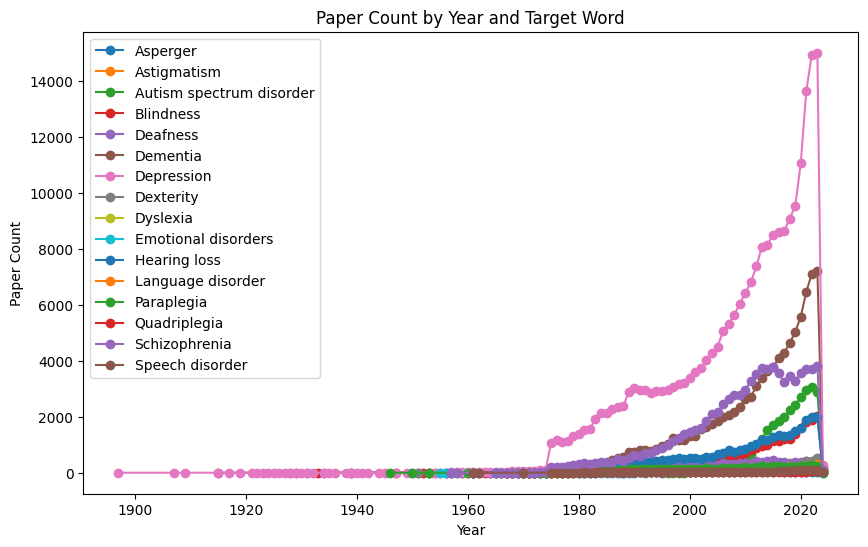

In [16]:
import matplotlib.pyplot as plt
# searchWord별 연도별 Row 수 계산
count_by_year = df.groupby(['searchWord', 'year']).size().reset_index(name='counts')

# Line graph 플로팅
plt.figure(figsize=(10, 6))
for searchWord, group in count_by_year.groupby('searchWord'):
    plt.plot(group['year'], group['counts'], label=searchWord, marker='o')

plt.xlabel('Year')
plt.ylabel('Paper Count')
plt.title('Paper Count by Year and Target Word')
plt.legend()
plt.show()

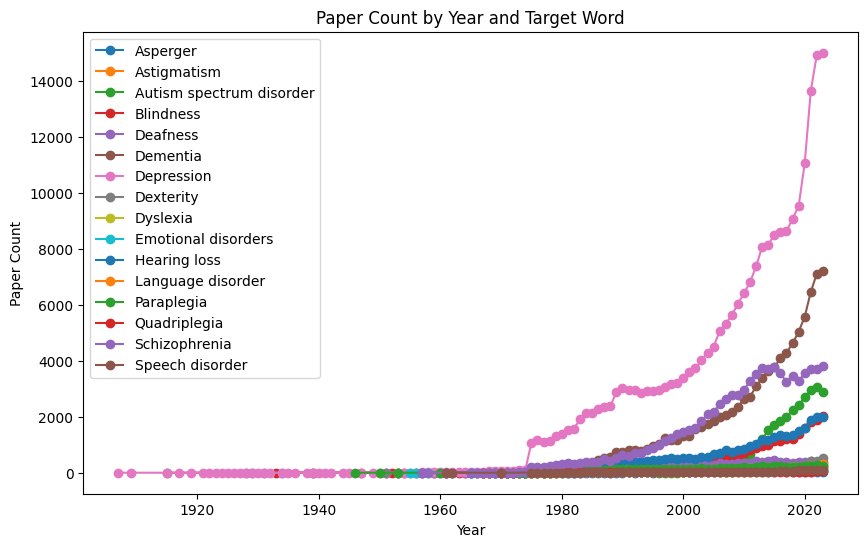

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 로드 (여기에는 생략)

# 년도 범위 설정
start_year = 1900
end_year = 2023

# searchWord별 연도별 Row 수 계산 (지정된 년도 범위 내에서만)
count_by_year = df[(df['year'] >= start_year) & (df['year'] <= end_year)].groupby(['searchWord', 'year']).size().reset_index(name='counts')

# Line graph 플로팅
plt.figure(figsize=(10, 6))
for searchWord, group in count_by_year.groupby('searchWord'):
    plt.plot(group['year'], group['counts'], label=searchWord, marker='o')

plt.xlabel('Year')
plt.ylabel('Paper Count')
plt.title('Paper Count by Year and Target Word')
plt.legend()
plt.show()